# Handwritten Digit classification using PyTorch

### Import PyTorch library 

- Import PyTorch by using the **```import torch```** command.

- You can check the version of PyTorch by using **```torch.__version__```** command.

- Use **```torch.cuda.is_available()```** to determine if your environment supports GPU, which should return **```True```**. 

- If **```torch.cuda.is_available()```** returns **```False```**, you should change the accelerator (```Edit->Notebook settings```) from **None** to **GPU** (Refer to lab sheet section 3.1.7). 

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available()) # Return True, if GPU is available

1.9.0+cu111
True


Import other necessary libraries

In [ ]:
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import numpy as np

import time

Define the hyperparameters of the neural network.

**You will need to modify some of the training parameters for answering the questions.**

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

# Training parameters
batch_size = 32
learning_rate = 0.1
num_epochs = 30
weight_decay_coef = 0 # Modify this for Q.4

## MNIST handwrittern digit dataset

Create the data loaders: one for **training** and one for **evaluation**.

In [ ]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualizing the dataset

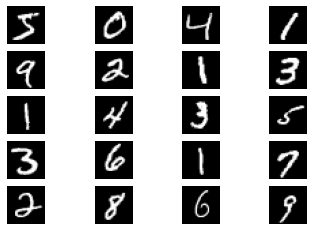

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure()
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    # Try to change: train_dataset -> test_dataset, and run it again
    img = train_dataset.__getitem__(i-1)[0][0].numpy()
    h, w = img.shape
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()

### Build a 4-layer Multi-Layer Perceptron (MLP)

![MLP](https://github.com/johnnysclai/EIE522/blob/master/simple_neural_network_header-768x377.jpg?raw=true)

Some people call it "3-layer" MLP, becuase there are 3 sets of trainable parameters.


In [ ]:
class MLP(nn.Module):
    # Define the structure
    def __init__(self, in_dim, h1_dim, h2_dim, out_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(in_dim, h1_dim, bias=True)
        self.layer2 = nn.Linear(h1_dim, h2_dim, bias=True)
        self.layer3 = nn.Linear(h2_dim, out_dim)

    # Define the forward pass operations    
    def forward(self, x):
        # Reshape the img: batch_size*28*28 -> batch_size*784 
        x = x.view(x.size(0), -1)
        
        x = self.layer1(x)
        #x = F.relu(x) # Uncommend it for adding ReLU activation. Modify it for Q.3
        x = self.layer2(x)
        #x = F.relu(x) # Uncommend it for adding ReLU activation. Modify it for Q.3
        x = self.layer3(x)
        return x

### Build a Convolutional Neural Network (CNN)

![CNN](https://github.com/johnnysclai/EIE522/blob/master/Mnist%20conv_revised.jpg?raw=true)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        
        return x

Create the models of the MLP and the CNN.

In [ ]:
# Create a model of the MLP
# Define the hyperparameter as follows: 
# in_dim=28*28, h1_dim=128, h2_dim=128, out_dim=10
model_mlp = MLP(in_dim=28*28, h1_dim=128, h2_dim=128, out_dim=10)

# Convert all model's trainable parameters to CUDA Tensor
# to train with GPU
model_mlp = model_mlp.cuda()

#-------------------------------------------------------
# Create a model of the CNN
model_cnn = CNN()
model_cnn = model_cnn.cuda()

We can display the details of the model.

In [ ]:
print(model_mlp)

print(model_cnn)

MLP(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=10, bias=True)
)
CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Also, we can list the number of trainable parameters in each layer.

**Show the number of trainable parameters in layer1 of the MLP and conv1 of the CNN**

In [ ]:
for param in model_mlp.layer1.parameters(): # Modify it for Q.1
    print('Shape of parameters: ', param.shape)
    print('Number of parameters: ', param.numel())

Shape of parameters:  torch.Size([128, 784])
Number of parameters:  100352
Shape of parameters:  torch.Size([128])
Number of parameters:  128


In [ ]:
for param in model_cnn.conv1.parameters(): # Modify it for Q.1
    print('Shape of parameters: ', param.shape)
    print('number of parameters: ', param.numel())

Shape of parameters:  torch.Size([10, 1, 5, 5])
number of parameters:  250
Shape of parameters:  torch.Size([10])
number of parameters:  10


Create a loss function and an optimizer.

In [ ]:
# Softmax operation is included inside the nn.CrossEntropyLoss function
# Refer to: http://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss 
CELoss = nn.CrossEntropyLoss()

# Stochastic gradient descent is used as the optimizer
# One for the MLP, another one for the CNN
SGD_mlp = optim.SGD(model_mlp.parameters(), lr=learning_rate, weight_decay=weight_decay_coef)
SGD_cnn = optim.SGD(model_cnn.parameters(), lr=learning_rate, weight_decay=weight_decay_coef)

## Create the functions to train and evaluate the model

In Python, **```def```** is used to define a function. We create **```train```** and **```test```** to train the model and evaluate the performance. 

In [ ]:
def train(loader, net, criterion, optimizer):
    start_time = time.time()

    # Make train model of the net is turned on
    net.train()

    running_loss = 0.0
    running_samples = 0.0
    running_correct = 0.0

    for data in loader:
        img, label = data

        running_samples += img.size(0)

        # Convert to CUDA Tensor variable
        img = img.cuda()
        label = label.cuda()

        # Feed forward
        output_score = net(img) # dim. of output_score: batch_size*10

        # Calculate the loss
        loss = criterion(output_score, label)

        # Backpropagation (3 steps)
        # 1. Clear the gradients (i.e. all become zero)
        # 2. Calculate the derivative of the loss with respect to the variables(trainable parameters)
        # 3. Update the parameters (i.e. model.parameters(), as defined above) by using the optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(output_score, 1)
        num_correct = (pred == label).sum().item()

        running_loss += loss.item()
        running_correct += num_correct

    # Calculate the average loss and top-1 accuracy for each epoch
    average_loss = running_loss / running_samples
    average_accuracy = running_correct / running_samples

    print('Training loss: {:.4f}, Acc: {:.4f} in {:.4f}'.format(
          average_loss, 
          average_accuracy,
          time.time()-start_time))
 
#---------------------------------------------------------------------------------
def test(loader, net, criterion):
    #In testing phase, no need to update the network.
    start_time = time.time()

    # Make eval model of the net is turned on
    net.eval()

    running_loss = 0.0
    running_samples = 0.0
    running_correct = 0.0

    for data in loader:
        img, label = data

        running_samples += img.size(0)

        # Convert to CUDA Tensor variable
        img = img.cuda()
        label = label.cuda()

        # Feed forward
        output_score = net(img) # dim. of output_score: batch_size*10

        # Calculate the loss
        loss = criterion(output_score, label)

        _, pred = torch.max(output_score, 1)
        num_correct = (pred == label).sum().item()

        running_loss += loss.item()
        running_correct += num_correct

    # Calculate the average loss and top-1 accuracy for each epoch
    average_loss = running_loss / running_samples
    average_accuracy = running_correct / running_samples

    print('Test loss: {:.4f}, Acc: {:.4f} in {:.4f}'.format(
          average_loss, 
          average_accuracy,
          time.time()-start_time))

In [ ]:
# For training and test the MLP/CNN,
# To train and test with CNN, change model_mlp->model_cnn and change SGD_mlp->SGD_cnn
for epoch in range(1, num_epochs+1):
    print('Epoch: ', epoch)
    train(train_loader, model_mlp, criterion=CELoss, optimizer=SGD_mlp) # Modify model_mlp, SGD_mlp for Q.2 and Q.4
    test(test_loader, model_mlp, criterion=CELoss) # Modify model_mlp for Q.2 and Q.4

Epoch:  1
Training loss: 0.0129, Acc: 0.8812 in 18.7893
Test loss: 0.0095, Acc: 0.9103 in 2.8349
Epoch:  2
Training loss: 0.0102, Acc: 0.9074 in 18.3187
Test loss: 0.0090, Acc: 0.9153 in 2.8562
Epoch:  3
Training loss: 0.0098, Acc: 0.9109 in 18.4622
Test loss: 0.0100, Acc: 0.9104 in 2.8047
Epoch:  4
Training loss: 0.0096, Acc: 0.9129 in 18.5406
Test loss: 0.0092, Acc: 0.9187 in 2.8270
Epoch:  5
Training loss: 0.0094, Acc: 0.9147 in 18.4840
Test loss: 0.0092, Acc: 0.9191 in 2.8798
Epoch:  6
Training loss: 0.0093, Acc: 0.9163 in 18.2891
Test loss: 0.0095, Acc: 0.9138 in 2.8962
Epoch:  7
Training loss: 0.0092, Acc: 0.9177 in 18.3794
Test loss: 0.0102, Acc: 0.9094 in 2.9078
Epoch:  8
Training loss: 0.0091, Acc: 0.9172 in 18.4641
Test loss: 0.0100, Acc: 0.9130 in 2.8920
Epoch:  9
Training loss: 0.0091, Acc: 0.9180 in 18.4236
Test loss: 0.0086, Acc: 0.9234 in 2.8403
Epoch:  10
Training loss: 0.0090, Acc: 0.9185 in 18.4456
Test loss: 0.0093, Acc: 0.9198 in 2.8223
Epoch:  11
Training loss: 0.0

In [ ]:
print('Display the value of the trainable parameters in each layer:')
for param in model_mlp.parameters(): # Modify for Q.4 (For CNN, change model_mlp->model_cnn)
  print('Mean: {:.4f} Min.: {:.4f} Max.:{:.4f}'.format(
      param.data.mean(), param.data.min(), param.data.max()))

Display the value of the trainable parameters in each layer:
Mean: -0.0002 Min.: -0.4908 Max.:0.4539
Mean: -0.0022 Min.: -0.7762 Max.:0.9742
Mean: 0.0002 Min.: -0.1409 Max.:0.1388
Mean: -0.0044 Min.: -0.2592 Max.:0.2794
Mean: 0.0019 Min.: -0.5141 Max.:0.3763
Mean: -0.0072 Min.: -1.2363 Max.:1.4880
